# Sanity test for UNet

This plots the model segmentation predictions versus the ground truth.

In [9]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
msk = np.load('test_predictions.npy')
test = np.load('msks_test.npy')

In [11]:
# Preprocess the segmentation masks for the ground truth (mode=1)
test[:,:,:,0] = test[:,:,:,0]+test[:,:,:,1]+test[:,:,:,2]+test[:,:,:,3]

Text(0.5,1,u'Ground truth')

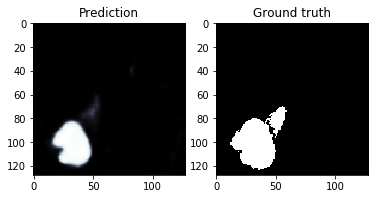

In [12]:
img = 400
plt.subplot(1,2,1)
plt.imshow(msk[img,:,:,0], cmap='bone')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test[img,:,:,0], cmap='bone')
plt.title('Ground truth')

Text(0.5,1,u'Ground truth')

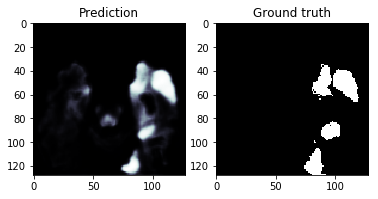

In [13]:
img = 520
plt.subplot(1,2,1)
plt.imshow(msk[img,:,:,0], cmap='bone')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test[img,:,:,0], cmap='bone')
plt.title('Ground truth')

Text(0.5,1,u'Ground truth')

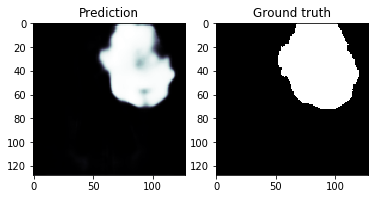

In [14]:
img = 1333
plt.subplot(1,2,1)
plt.imshow(msk[img,:,:,0], cmap='bone')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test[img,:,:,0], cmap='bone')
plt.title('Ground truth')

Text(0.5,1,u'Ground truth')

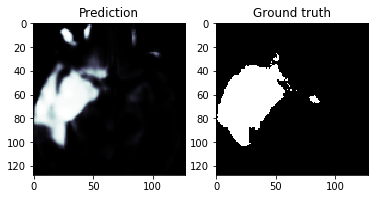

In [15]:
img = 2540
plt.subplot(1,2,1)
plt.imshow(msk[img,:,:,0], cmap='bone')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test[img,:,:,0], cmap='bone')
plt.title('Ground truth')

Text(0.5,1,u'Ground truth')

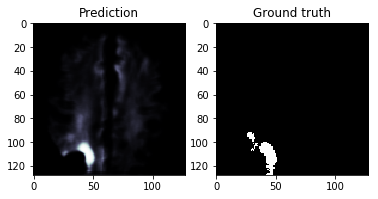

In [16]:
img = 5533
plt.subplot(1,2,1)
plt.imshow(msk[img,:,:,0], cmap='bone')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test[img,:,:,0], cmap='bone')
plt.title('Ground truth')

Text(0.5,1,u'Ground truth')

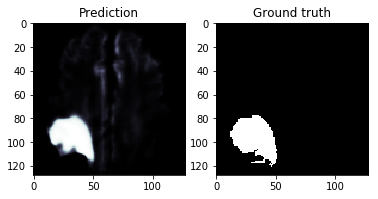

In [17]:
img = 2121
plt.subplot(1,2,1)
plt.imshow(msk[img,:,:,0], cmap='bone')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test[img,:,:,0], cmap='bone')
plt.title('Ground truth')

Text(0.5,1,u'Ground truth')

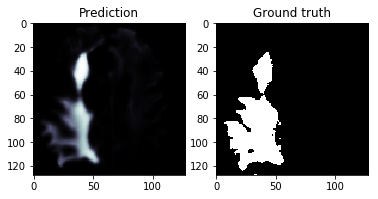

In [18]:
img = 4444
plt.subplot(1,2,1)
plt.imshow(msk[img,:,:,0], cmap='bone')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test[img,:,:,0], cmap='bone')
plt.title('Ground truth')